### Project Details:

Before you start Task 1, make sure you've read through the project description in "Project_AIPR.pdf" (used for all three tasks) found in the Files page.

### Overview of Task 1

Task 1 concerns preparing the data for later use in Tasks 2 and 3.
As part of this you will:

Handle the missing values in the data.
Preprocess the attribute values into an appropriate form to be used as input to an algorithm (as described in Project_AIPR.pdf).
Visualize the data using different techniques in order to get a sense of what it contains.
Files provided for Task 1

Task 1 uses three existing files, none of which should be part of the final submission.
Kumar2018_Article_APositionAndRotationInvariantF.pdf (A reference paper for gesture recognition)
train-final.csv
test-final.csv
All of the files can be found in the Files page.

### Handle the missing values in the data

The data in "train-final.csv" and "test-final.csv" is incomplete as there are some values that are missing. Since these are .csv (Comma-Separated Values) files this will be difficult to see in a text editor as the missing values will simply show up as two commas with nothing in between them. A better way to visualize them is to use spreadsheet software like Excel or to use RapidMiner directly. Before the data can be used these missing values needs to be replaced with filler values. How you do this is up to you, but (as detailed later) the process must be detailed in the report and the procedure for selecting replacement values must be justified. Note: If you handle the data by creating new files these new files must be part of the submission.

### Preprocess the attributes

Apply any preprocessing procedures you think would help with prediction in Tasks 2 and 3. You may use several preprocessing procedures at once and even create several different "pipelines" of procedures to see how they perform in the following tasks. Any procedures created must be reported and justified in the report.

You will be allowed to change anything you do in this task for the later tasks if need be (those tasks will have more information).

### Visualize the data

Create visualization of the data before and after preprocessing. You must at least include 2 such visualizations in the report (description and images) as well as justifications for their use and what you learned about the data from them.

### Submission

The submission consists of two parts:

The project:
The RapidMiner project (or Python code/Matlab files) that contains your solution.
Any other files used that are different from those provided to you (if you edited the provided files directly those edited versions should be included).
Anything else needed to run your project (including instructions on how to do so, if it's not self-obvious).
The report:
A report detailing how you solved the task, justification for your choices (even for choices not to do something), images of the visualizations, and what those visualizations tell you about the data and preprocessing.
Additional material

The files also include a paper "Kumar2018_Article_APositionAndRotationInvariantF.pdf" which you can consult for deeper information about gesture recognition.

The files also include "combined-1.zip" which includes the raw gesture time series as described in "Project_AIPR.pdf". You don't need to use them, but they can be used for more advanced methods for handling missing values or preprocessing.

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("train-final.csv", header=None)

# Rename columns for easier reading

# Feature columns
df_train.rename({i:f"positions_mean_{i}" for i in range(60)}, axis=1, inplace=True)
df_train.rename({i:f"positions_std_{i}" for i in range(60,120)}, axis=1, inplace=True)
df_train.rename({i:f"angles_mean_{i}" for i in range(120,180)}, axis=1, inplace=True)
df_train.rename({i:f"angles_std_{i}" for i in range(180,240)}, axis=1, inplace=True)

# Label columns
df_train.rename({240 : "label_name", 241 : "label_code"}, axis=1, inplace=True)

train_feature_columns = df_train.columns[:-2]
n_classes = df_train.label_name.nunique()
 
df_train

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239,label_name,label_code
0,-0.479730,0.726079,2.403713,-0.481913,0.540689,2.455865,-0.646274,0.406351,2.428461,-0.312905,...,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320,bye,5
1,0.051888,0.646871,2.409750,0.060117,0.451912,2.449198,-0.106647,0.344324,2.461468,0.183852,...,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291,you,30
2,-0.002692,0.624926,2.240212,0.018586,0.435987,2.269613,-0.152985,0.336314,2.305371,0.164105,...,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623,thankyou,26
3,-0.029336,0.664426,2.443440,-0.023426,0.480809,2.451577,-0.203417,0.353489,2.506273,0.119183,...,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313,name,20
4,0.065604,0.639172,2.377587,0.069247,0.447377,2.405972,-0.092707,0.339007,2.368022,0.231172,...,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550,love,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-0.153429,0.653027,2.290336,-0.202696,0.460290,2.337915,-0.285067,0.331688,2.247679,-0.060992,...,0.485318,0.522038,0.435164,0.464692,0.536148,0.538248,0.338490,0.536627,go,15
536,-0.270779,0.692372,2.418405,-0.309432,0.513018,2.427828,-0.367138,0.339803,2.340697,-0.174124,...,0.787530,0.375785,0.490460,0.512968,0.463116,0.507656,0.280617,0.563687,home,17
537,-0.293375,0.679736,2.413071,-0.332449,0.499503,2.442463,-0.395068,0.346635,2.347341,-0.197936,...,0.575436,0.505751,0.331261,0.389225,0.598488,0.617464,0.316425,0.504178,rain,22
538,-0.497183,0.534425,2.322565,-0.557379,0.353817,2.343797,-0.614599,0.217394,2.218595,-0.435612,...,0.759135,0.345677,0.341312,0.408758,0.589787,0.561659,0.399114,0.504443,my,19


In [3]:
# Look for columns that have missing values
columns_null_sum = df_train.isnull().sum()
columns_with_nulls = columns_null_sum[columns_null_sum > 0]

print("Total amount of missing values in the dataframe:", df_train.isnull().sum().sum())
print("Missing values in the following column indexes (and missing value count):\n", columns_with_nulls)

for i in columns_with_nulls.index:
    print("Column", i, "min", 
        "min", df_train[i].min(),
        "max", df_train[i].max(),
        "mean", df_train[i].mean(),
        "median", df_train[i].median(),
        "stdev", df_train[i].std())

Total amount of missing values in the dataframe: 21
Missing values in the following column indexes (and missing value count):
 positions_mean_7     4
positions_mean_8     4
positions_mean_9     4
positions_mean_14    3
positions_mean_15    3
positions_mean_16    3
dtype: int64
Column positions_mean_7 min min 0.215896382 max 0.461243507 mean 0.3345816778488809 median 0.3402856735 stdev 0.057018788609597346
Column positions_mean_8 min min 1.958559157 max 2.609595816 mean 2.317619830130598 median 2.329260976 stdev 0.13021341268533468
Column positions_mean_9 min min -0.529039607 max 0.399172979 mean -0.038419459190298495 median -0.054838042000000004 stdev 0.23820936403768025
Column positions_mean_14 min min 1.826847652 max 2.619495288 mean 2.2551130643202977 median 2.252075494 stdev 0.1635205512147459
Column positions_mean_15 min min -0.441503043 max 0.551751687 mean 0.08066904289199256 median 0.081935805 stdev 0.24906213741985422
Column positions_mean_16 min min 0.013729695 max 0.62729841

In [4]:
# As we have low amount of missing values and we assume they have no significance by themselves, we replace them
# with the mean of each series
df_train[columns_with_nulls.index] = df_train[columns_with_nulls.index].fillna(df_train[columns_with_nulls.index].mean())

assert df_train.isnull().sum().sum() == 0

In [5]:
from sklearn import preprocessing
import numpy as np

# Scale the dataframe
def preprocess(df):

    scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    scaled_values = scaler.fit_transform(df.values)
    #scaled_values = scaled_values.astype(np.float32)
    return pd.DataFrame(scaled_values)

df_train[train_feature_columns] = preprocess(df_train[train_feature_columns])
df_train

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239,label_name,label_code
0,-1.323633,1.421746,0.733025,-1.232600,1.399904,0.822277,-1.422333,1.264565,0.855193,-1.157657,...,1.047194,-1.135466,0.769486,0.395003,-0.513685,0.020178,2.181665,-1.544711,bye,5
1,1.003039,0.078953,0.794440,1.093898,-0.102009,0.757567,0.931582,0.171659,1.109858,0.937443,...,-1.823802,1.842487,-0.235120,-1.990480,1.426960,-0.876203,-2.053768,1.825020,you,30
2,0.764166,-0.293088,-0.930321,0.915639,-0.371414,-0.985672,0.729450,0.030518,-0.094503,0.854160,...,-0.791318,0.629031,1.002887,0.942327,-1.474741,0.680542,0.412169,-0.811236,thankyou,26
3,0.647555,0.376563,1.137173,0.735317,0.386874,0.780659,0.509463,0.333136,1.455556,0.664697,...,0.884029,-0.850038,-0.147232,-0.450141,0.702284,0.228297,1.694685,-1.276755,name,20
4,1.063069,-0.051572,0.467238,1.133087,-0.178730,0.337967,0.992393,0.077981,0.388881,1.137018,...,0.485131,0.432586,-0.583229,-0.954479,1.125046,-0.296817,1.861857,-1.176475,love,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.104449,0.183302,-0.420391,-0.034147,0.039739,-0.322666,0.153295,-0.050988,-0.539629,-0.095202,...,-1.285473,1.118575,-0.196557,0.073068,0.380258,0.632359,-0.935488,0.280354,go,15
536,-0.409141,0.850326,0.882491,-0.492275,0.931777,0.550124,-0.204708,0.092004,0.178055,-0.572343,...,1.589188,-1.014983,0.432809,0.611359,-0.897387,0.322098,-1.605163,0.798543,home,17
537,-0.508033,0.636107,0.828228,-0.591072,0.703132,0.692188,-0.326546,0.212378,0.229314,-0.672771,...,-0.428259,0.880984,-1.379166,-0.768425,1.470878,1.435754,-1.190814,-0.341015,rain,22
538,-1.400019,-1.827348,-0.092519,-1.556511,-1.761556,-0.265569,-1.284163,-2.064829,-0.764028,-1.675181,...,1.319086,-1.454198,-1.264767,-0.550617,1.318654,0.869789,-0.233981,-0.335954,my,19


In [6]:
# Take a look at how many occurrences we have of each label
df_train.label_name.value_counts()

child        25
study        22
come         22
no           22
my           22
home         21
big          21
welcome      20
rain         20
daily        20
you          20
name         19
strong       19
love         18
born         18
wind         18
day          17
bye          17
afternoon    17
calendar     17
hello        16
cloud        16
dance        16
yes          15
baby         15
thankyou     15
enjoy        14
sorry        13
dark         13
go           12
Name: label_name, dtype: int64

Explained variation per principal component: [0.10748785 0.09725905]
Total variance explained by 2 PCA components 0.2047469075922841


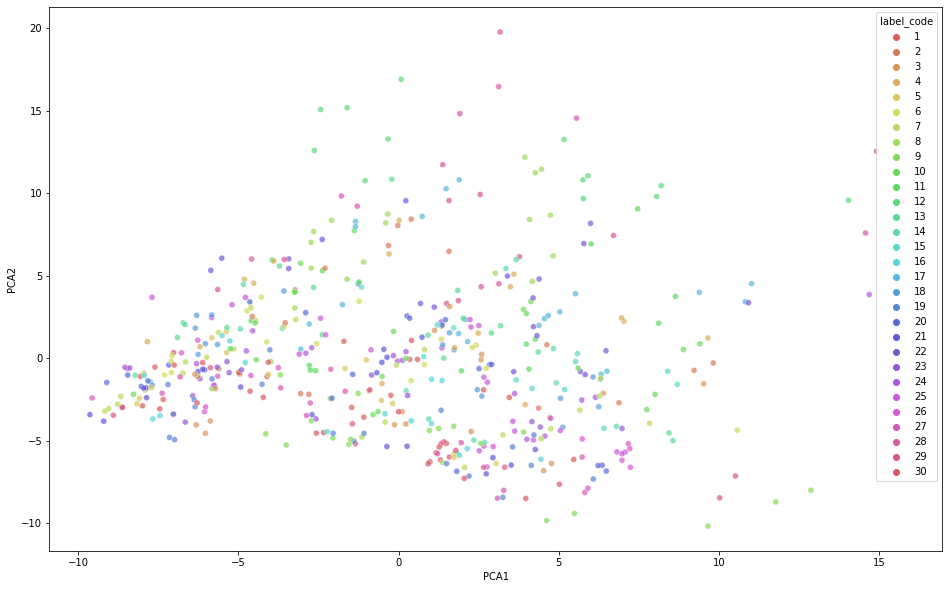

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

def PCA_scatter(df, feature_columns, label_column):

    df = df.copy()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[feature_columns].values)

    print(f"Explained variation per principal component: {pca.explained_variance_ratio_}")
    print(f"Total variance explained by {pca_result.shape[1]} PCA components", np.sum(pca.explained_variance_ratio_))

    df[['PCA1', 'PCA2']] = pca_result[:,:2]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="PCA1", y="PCA2",
        hue=label_column,
        palette=sns.color_palette("hls", n_classes),
        data=df,
        legend="full",
        alpha=0.7
    )

PCA_scatter(df_train, train_feature_columns, "label_code")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 540 samples in 0.000s...
[t-SNE] Computed neighbors for 540 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 540 / 540
[t-SNE] Mean sigma: 5.163062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.838860
[t-SNE] KL divergence after 1000 iterations: 0.886682


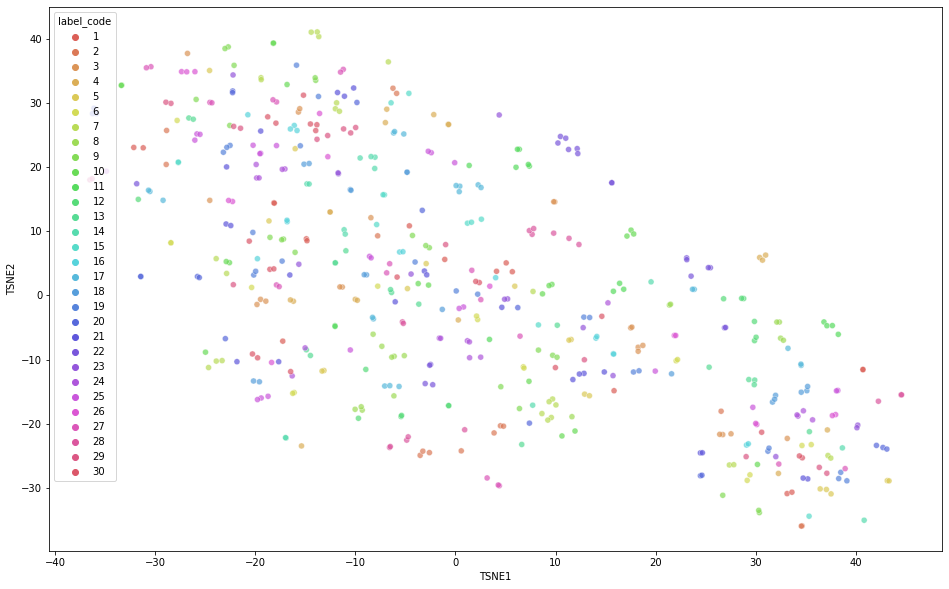

In [8]:
def tSNE_scatter(df, feature_columns, label_column):

    df = df.copy()

    # Let's also try t-SNE
    tsne = TSNE(n_components=2, verbose=1, random_state=9999) #, perplexity=80, n_iter=10000)
    tsne_results = tsne.fit_transform(df[feature_columns].values)

    df_train['TSNE1'] = tsne_results[:,0]
    df_train['TSNE2'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="TSNE1", y="TSNE2",
        hue=label_column,
        palette=sns.color_palette("hls", n_classes),
        data=df_train,
        legend="full",
        alpha=0.7
    )

tSNE_scatter(df_train, train_feature_columns, "label_code")

Both PCA and tSNE on the full dataset do not give any obvious clusters/separation. This data set is very wide with relatively few samples per class, so let's try some features selection to reduce the number of features to see if we can do bettter with PCA and/or tSNE plots.

In [9]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# For slow selectors we may need to sample
#ix_subset = np.random.choice(np.arange(df_train.shape[0]), 400, replace=False)
df_train_subset = df_train.copy()

#selector = SequentialFeatureSelector(estimator=RidgeClassifier(), n_features_to_select = 80, cv = 3, 
#    direction ='forward', n_jobs=-1)
#selector = SelectFromModel(estimator=SVC(kernel="linear"))
selector = SelectFromModel(estimator=RandomForestClassifier())

selector.fit(df_train_subset[train_feature_columns], df_train_subset.label_code)

selected_columns = df_train[train_feature_columns].columns[selector.get_support()]
print("Reduced feature count", len(selected_columns))

Reduced feature count 64


Explained variation per principal component: [0.23298339 0.13376217]
Total variance explained by 2 PCA components 0.3667455639563858


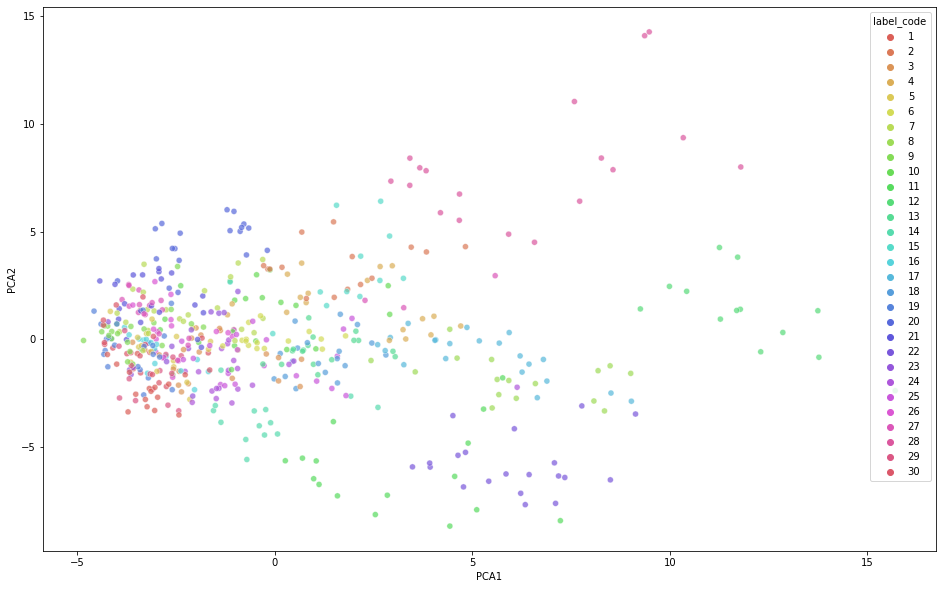

In [10]:
# Try a PCA scatter plot again with the smaller feature set
PCA_scatter(df_train, selected_columns, "label_code")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 540 samples in 0.000s...
[t-SNE] Computed neighbors for 540 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 540 / 540
[t-SNE] Mean sigma: 3.104401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.538612
[t-SNE] KL divergence after 1000 iterations: 0.761165


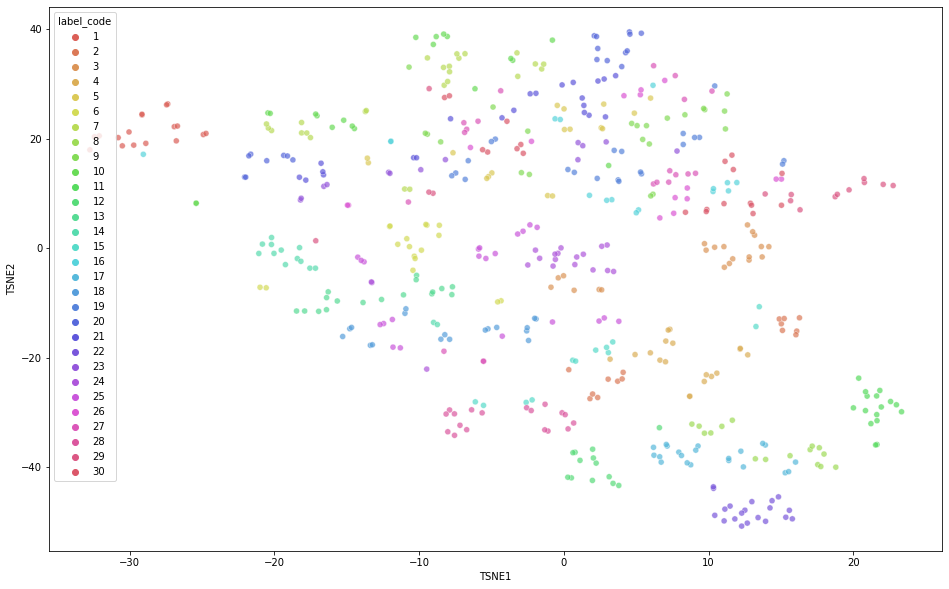

In [11]:
# Try an t-SNE scatter plot again with the smaller feature set
tSNE_scatter(df_train, selected_columns, "label_code")

Both PCA and t-SNE look better with some clusters appearning. t-SNE appears to be better at separating with some clusters clearly separated/visible. Although many still appear hard to separate.